<h1>Marble Win Probability Tool</h1>

<p> The purpose of the tool below is to provide a deeper level of analytics for marble racing, inspired by Jelle's Marble Racing. 

Specifically, this tool predicts 1) the probability of winning the championship and 2) probability of getting a spot on the podium for each marble, given the current standings and some season parameters.
</p>

In [1]:
# marble racing win probability

from scipy.stats import binom
from random import random, shuffle, sample
from copy import copy
import matplotlib.pyplot as plt

# function to get censored binomial pdf
def censored_bin_cdf(N,p):
    # Binomial(N,p)
    # Output dictionary {N:p(N)} s.t. p(N)>=censor

    # set censor
    censor = 0.01
    # build pdf
    pdf = binom.pmf(list(range(N+1)),N,p)
    # censor where p(N)>=censor & re-normalize
    pdf_censor = [float(x) for x in pdf if x>=censor]
    pdf_sum = sum(pdf_censor)
    pdf_censor_normalized = [number/pdf_sum for number in pdf_censor]
    # compute cdf from censored pdf
    cdf_censor = [ sum(pdf_censor_normalized[:ii+1]) for
                   ii in range(len(pdf_censor))]
    # get N values for censors
    N_censor = [i for i in range(N+1) if pdf[i]>=censor]
    # output lists
    return N_censor, cdf_censor

# function to use CDF method to sample RV
def cdf_method(X_list,cdf_list):
    # X_list = list of X values
    # cdf_list = list of cdf values for X

    # sample from random U(0,1)
    u = random()
    # set placeholder
    N = X_list[0]
    # find greatest number from cdf_list that is greater
    for idx in range(len(cdf_list)):
        if u > cdf_list[idx]:
            N = X_list[idx]+1
    # return N
    return N

# function to generate random race result
def random_race_result(m,N,marble_names):
    # m = number of marbles in race
    # N = number of marbles that finish race
    # marble_names = list of marble names

    # select (m-N) marbles to not finish the race
    k = m-N
    DNF_list = sample(marble_names,k)
    # select marbles that did finish
    finished_list = [marble for marble in marble_names if marble not in DNF_list]
    # randomly assign order for placing
    place_assignments = list(range(1,N+1))
    shuffle(place_assignments)
    # use dictionary to assign results
    race_result = dict()
    for ii in range(len(finished_list)):
        race_result[finished_list[ii]] = place_assignments[ii]
    for jj in range(k):
        race_result[DNF_list[jj]]='DNF'
    # return results
    return race_result

# function to score points based on race result
def points_score(race_result,points_key,marble_names):
    # race_result = dict result of a random race, marble:place
    # points key = dict of points given for place, place:points
    # marble_names = list of marble names

    # create dict to hold marble:points
    race_points_dict = dict()
    # loop thru marble_names and assign points
    for marble in marble_names:
        place = race_result[marble]
        points = points_key[place]
        race_points_dict[marble] = points
    # return points assignment
    return race_points_dict

# function to update point totals for each marble based on last race
def update_points_totals(entering_points_dict,race_points_dict,marble_names):
    # entering_points_dict = dict with points before race
    # race_points_dict = dict with points scored from race
    # marble_names = list of marble names

    # create dict to hold total points
    total_points_dict = dict()
    # loop thru marble_names and total points
    for marble in marble_names:
        total_points_dict[marble] = entering_points_dict[marble] + race_points_dict[marble]
    # return updates totals
    return total_points_dict

# function to identify winner & podium finishes
def championship_result(total_points_dict,marble_names):
    # total_points_dict = dict with total points for season, marble:season total points
    # marble_names = list of marble names

    # identify winner
    winner = max(total_points_dict, key=total_points_dict.get)
    # identify podium
    podium = list()
    # make copy of total_points_dict
    champ_points_dict = copy(total_points_dict)
    # add winner & remove from dict
    podium.append(winner)
    del champ_points_dict[winner]
    # add 2nd place & remove from dict
    second = max(champ_points_dict, key=champ_points_dict.get)
    podium.append(second)
    del champ_points_dict[second]
    # add 3rd place
    third = max(champ_points_dict, key=champ_points_dict.get)
    podium.append(third)
    # return output as tuple of 2 lists
    return [winner],podium

# function to simulate M times for given N
def simulate_season_one_time(R,p,m,marble_names,current_points_dict,points_key):
    # R = number of races remaining
    # p = average finish probability
    # m = number of marbles in race
    # marble_names = list of marble names
    # current_points_dict = dict with points right now (before simulation)
    # points_key = dict with points awarded for each place, place:points

    # initialize validation variable, start at zero
    sim_points_dict = dict()
    for marble in marble_names:
        sim_points_dict[marble] = 0
    # initialize total points dict
    total_points_dict = copy(current_points_dict)
    # compute cdf for N finishers
    N_list,cdf_limits = censored_bin_cdf(m,p)
    # loop for R times (R remaining races)
    for race_num in range(R):
        # choose N 
        # 1) generate cdf
        N_list, cdf_list = censored_bin_cdf(m,p)
        # 2) use cdf method to get Ni
        N = cdf_method(N_list, cdf_list)
        # run a race
        race_result = random_race_result(m,N,marble_names)
        # total race points
        race_points_dict = points_score(race_result,points_key,marble_names)
        # add race points to validation variable & update total points
        for marble in marble_names:
            # update validation variable
            sim_points_dict[marble] = sim_points_dict[marble] + race_points_dict[marble]
            # update total points
            total_points_dict[marble] = total_points_dict[marble] + race_points_dict[marble]
    # Choose champion & podium
    winner_list,podium_list = championship_result(total_points_dict,marble_names)
    # return outputs: sim_points_dict, winner_list, podium_list
    #print('winner: '+winner_list[0])
    #print('podium: '+str(podium_list))
    #print(total_points_dict)
    return sim_points_dict, winner_list, podium_list
            

# function to run full simulation of season
def simulate_season(R,p,m,marble_names,current_points_dict,points_key):
    # R = number of races remaining
    # p = average finish probability
    # m = number of marbles in race
    # marble_names = list of marble names
    # current_points_dict = dict with points right now (before simulation)
    # points_key = dict with points awarded for each place, place:points

    # set simulation count
    L = 2_000*m
    # initialize validation variable, start at zero
    points_validation_dict = dict()
    for marble in marble_names:
        points_validation_dict[marble] = 0
    # initialize champion counter dict
    champ_count_dict = dict()
    for marble in marble_names:
        champ_count_dict[marble] = 0
    # initialize podium counter dict
    podium_count_dict = copy(champ_count_dict)
    # loop until L seasons
    for sim_number in range(L):
        # simulate season one time
        sim_points_dict, winner_list, podium_list = \
                         simulate_season_one_time(R,p,m,marble_names,current_points_dict,points_key)
        # add sim points to validation
        for marble in marble_names:
            points_validation_dict[marble] = points_validation_dict[marble] + \
                                             sim_points_dict[marble]
        # update champion count
        for marble in winner_list:
            champ_count_dict[marble] += 1
        # update podium count
        for marble in podium_list:
            podium_count_dict[marble] += 1
    # compute probability for champion & podium
    champ_prob_dict = dict()
    podium_prob_dict = dict()
    for marble in marble_names:
        champ_prob_dict[marble] = champ_count_dict[marble]/L*100
        podium_prob_dict[marble] = podium_count_dict[marble]/L*100
    # print dicts
    #print('Champion Probability:')
    #print(champ_prob_dict)
    #print('Podium Probability:')
    #print(podium_prob_dict)
    # plot championship results
    champ_prob_dict = dict(sorted(champ_prob_dict.items(), key=lambda item: item[1]))
    champ_marbles = list(champ_prob_dict.keys())
    champ_prob = list(champ_prob_dict.values())
    plt.figure()
    plt.barh(champ_marbles,champ_prob)
    for ii in range(len(champ_prob)):
        plt.text(champ_prob[ii]+4, champ_marbles[ii],
                 str(round(champ_prob[ii]*10)/10), ha = 'center', va = 'center')
    plt.title('Who will be the Champion?')
    plt.xlabel('Champion Probability')
    plt.ylabel('Marble Name')
    plt.xlim([0,max(champ_prob)+20])
    plt.grid()
    plt.show()
    # plot championship results
    podium_prob_dict = dict(sorted(podium_prob_dict.items(), key=lambda item: item[1]))
    podium_marbles = list(podium_prob_dict.keys())
    podium_prob = list(podium_prob_dict.values())
    plt.figure()
    plt.barh(podium_marbles,podium_prob)
    for ii in range(len(podium_prob)):
        plt.text(podium_prob[ii]+8, podium_marbles[ii],
                 str(round(podium_prob[ii]*10)/10), ha = 'center', va = 'center')
    plt.title('Who will get on the Podium?')
    plt.xlabel('Podium Probability')
    plt.ylabel('Marble Name')
    plt.xlim([0,110])
    plt.grid()
    plt.show()
    # plot validation histogram
    total_sim_points = sum(list(points_validation_dict.values()))
    for marble in marble_names:
        points_validation_dict[marble] = points_validation_dict[marble]/total_sim_points*m*100
    validation_marbles = list(points_validation_dict.keys())
    validation_points = list(points_validation_dict.values())
    plt.figure()
    plt.bar(validation_marbles,validation_points)
    plt.title('Simulation Validation: Points Total by Marble')
    plt.xlabel('Marble Name')
    plt.xticks(rotation=90)
    plt.ylabel('Percent of Expected Simulation Points')
    plt.axhline(y=101, color='r', linestyle='--')
    plt.axhline(y=99, color='r', linestyle='--')
    plt.ylim([90,103])
    plt.grid()
    plt.show()
    # return output dicts
    return champ_prob_dict, podium_prob_dict

# Test data B
R = 2
p = 0.95
m = 20
marble_names = ['WOD','BLF','ELC','POL','REF','H2B','BPL',
                'MMM','DRA','PHX','CCE','BLM','COM','GRA',
                'SUP','LOP','SLI','BBL','GHO','WWD']
current_points_dict = {'WOD':28,'BLF':26,'ELC':23,'POL':55,'REF':23,'H2B':15,'BPL':37,
                       'MMM':58,'DRA':30,'PHX':53,'CCE':5,'BLM':41,'COM':48,'GRA':6,
                       'SUP':45,'LOP':36,'SLI':24,'BBL':31,'GHO':45,'WWD':40}
points_key = {1:20, 2:17, 3:14, 4:12, 5:11, 6:10, 7:9, 8:9,
              9:7, 10:6, 11:5, 12:4, 13:3, 14:2, 15:1, 16:1,
              17:1, 18:1, 19:1, 20:1, 'DNF':0}

# single season simulation
def test1():
    X = simulate_season_one_time(R,p,m,marble_names,current_points_dict,points_key)
    return X

# multi-season simulation
def test2():
    X = simulate_season(R,p,m,marble_names,current_points_dict,points_key)
    return X

# generate accurate test data
def gen_test_data():
    # initialize dict at 0
    current_points_dict = dict()
    for marble in marble_names:
        current_points_dict[marble] = 0
    # simulate R=5 races
    Y = simulate_season_one_time(5,p,m,marble_names,current_points_dict,points_key)
    

<p> Try it out with our example data below, or edit for your own inputs: <p\>

In [2]:
R = 2 # 2 races left in the season
p = 0.95 # 95% average finishing rate
m = 20 # 20 marble contestants
# list of the names of the marbles in the league/season
marble_names = ['WOD','BLF','ELC','POL','REF','H2B','BPL',
                'MMM','DRA','PHX','CCE','BLM','COM','GRA',
                'SUP','LOP','SLI','BBL','GHO','WWD']
# how many points each marble has as of "today", i.e. WOD currently has 28 points
current_points_dict = {'WOD':28,'BLF':26,'ELC':23,'POL':55,'REF':23,'H2B':15,'BPL':37,
                       'MMM':58,'DRA':30,'PHX':53,'CCE':5,'BLM':41,'COM':48,'GRA':6,
                       'SUP':45,'LOP':36,'SLI':24,'BBL':31,'GHO':45,'WWD':40}
# awarded points system for each finish place, i.e. a 1st place finish earns 20 points
points_key = {1:20, 2:17, 3:14, 4:12, 5:11, 6:10, 7:9, 8:9,
              9:7, 10:6, 11:5, 12:4, 13:3, 14:2, 15:1, 16:1,
              17:1, 18:1, 19:1, 20:1, 'DNF':0}

<p> Running the command below will generate the probability results</p>

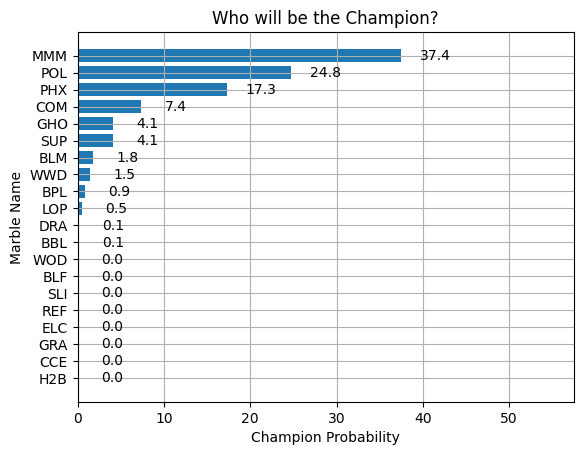

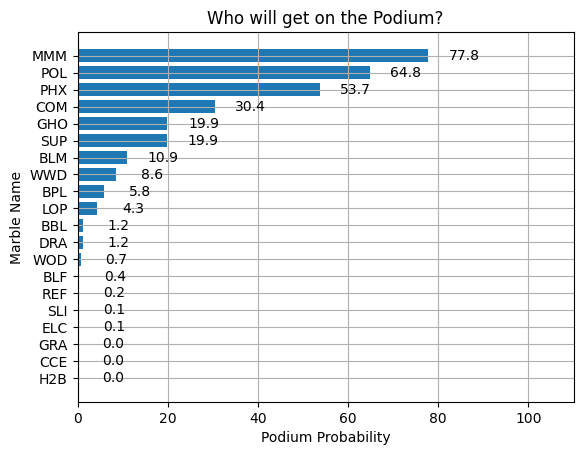

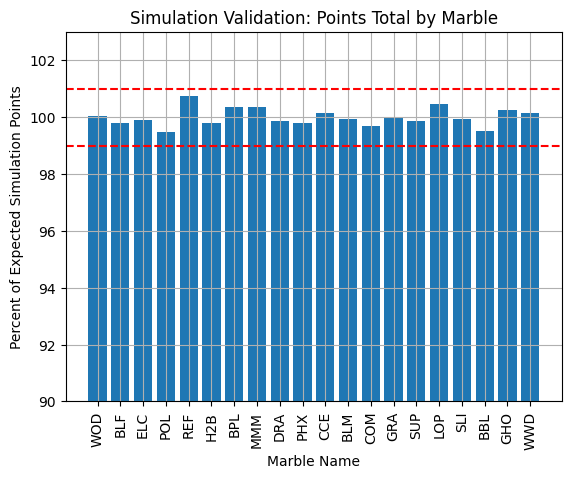

In [3]:
X = simulate_season(R,p,m,marble_names,current_points_dict,points_key)

<p> Above you can see 3 plots: 
1) Probability of each marble winning the championship
2) Probability of each marble getting on the podium
3) A validation of the randomness of the simulation. If any of the blue bars is outside of the red critical region, the simulation should be re-run because it may not be fully accurate. This should not happen often. </p>